# Class imbalance and model validation
Demo for the DIPA Data61 Course: Model Validation, Uncertainty and Missing Data

Dependencies:
- numpy
- scipy
- jupyter
- matplotlib
- scikit learn
- pandas

$\DeclareMathOperator*{\argmin}{\arg\!\min}$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, log_loss
from IPython.display import display, HTML

%matplotlib inline
np.random.seed(666)  # fix random seed
FIGSIZE = (16, 9)

## Generate data

Let's run with the cancer diagnosis problem, imagine the blue points are the positive cancer diagnosis.
10% of the sample have cancer, 90% do not.

- We care about diagnosing cancer
- it's bad to *miss* a positive case - we care about getting ALL the true positives (**TPR/recall**)
- not so bad to mis-diagnose as positive - we don't really care about precision or false positives

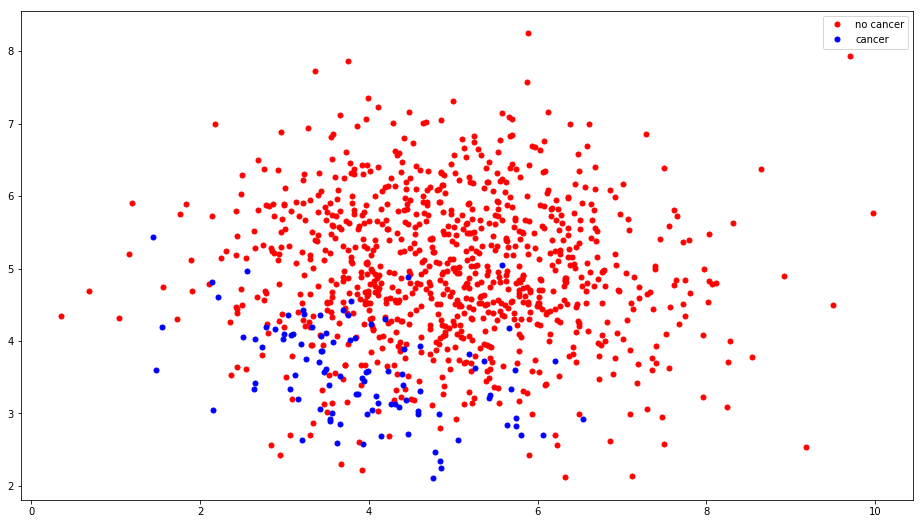

In [2]:
# class 1
n1 = 900 
mean1 = [5, 5]
cov1 = [
    [2.0, -0.1],
    [-0.1,  1.0]
]

X1 = np.random.multivariate_normal(mean1, cov1, n1)
Y1 = np.zeros(n1)

# class 2
n2 = 100 
mean2 = [4, 3.7]
cov2 = [
    [1.0, -0.3],
    [-0.3,  0.5]
]

X2 = np.random.multivariate_normal(mean2, cov2, n2)
Y2 = np.ones(n2)

# Mix them together
X = np.vstack((X1, X2))
Y = np.concatenate((Y1, Y2))


# Plot
def plot_data():
    pl.plot(*X1.T, 'r.', label='no cancer', markersize=10)
    pl.plot(*X2.T, 'b.', label='cancer', markersize=10)
    pl.legend()
    pl.show()

pl.figure(figsize=FIGSIZE)
plot_data()

## Generate one fold (train/test split)

- Normally we would to 5 or 10 K-fold, this is just easier to demonstrate
- We do a **stratified** split of the data to preserve class proportions with high probability!
- 80% train, 20% test

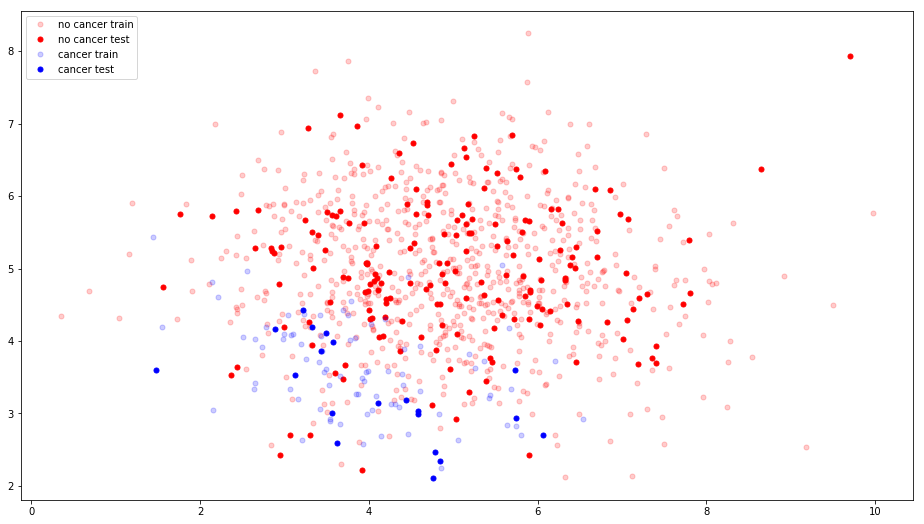

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.2,
    stratify=Y  # Note this!
)

# Plot
def plot_split_data():
    pl.plot(*X_train[y_train==0, :].T, 'r.', label='no cancer train', markersize=10, alpha=0.2)
    pl.plot(*X_test[y_test==0, :].T, 'r.', label='no cancer test', markersize=10)
    pl.plot(*X_train[y_train==1, :].T, 'b.', label='cancer train', markersize=10, alpha=0.2)
    pl.plot(*X_test[y_test==1, :].T, 'b.', label='cancer test', markersize=10)
    pl.legend()
    pl.show()
    
pl.figure(figsize=FIGSIZE)
plot_split_data()

## Naive classifiers
First, lets make two *naive* classifiers:
- one that always predicts negative (0)
- one that randomly samples at the base rate, $y^* \sim \text{Bernoulli}(y^*|p=0.1)$

In [4]:
# Always predict 0/negative
class AlwaysNeg():
    def predict(self, X_query):
        y_bar = np.zeros(X_query.shape[0])
        return y_bar
    
# Predict randomly according to the base rate of the training labels
class Random():
    def fit(self, X_train, y_train):
        self.p =  sum(y_train) / len(y_train)
        return self
        
    def predict(self, X_query):
        y_bar = np.random.binomial(n=1, p=self.p, size=X_query.shape[0])
        return y_bar
    
    def predict_proba(self, X_query):
        n = X_query.shape[0]
        p = np.ones((n, 2))
        p[:, 0] = 1 - self.p
        p[:, 1] = self.p
        return p
    
# Helper function for scoring the prediction results
def score_result(y_bar, name, p=None):
    n = sum(y_test == 0)
    fp = sum(y_bar[y_test == 0])
    rdict = {
        "Accuracy": accuracy_score(y_test, y_bar),
        "FPR": fp / n,
        "Precision": precision_score(y_test, y_bar),
        "Recall (TPR)": recall_score(y_test, y_bar),
        "Log loss": np.nan
    }
    
    if p is not None:
        rdict["Log loss"] = log_loss(y_test, p)

    res = pd.DataFrame(rdict, index=[name])
    return res

# Run the prediction then score
def score_classifier(clf, name): 
    y_bar = clf.predict(X_test)
    p = None
    if hasattr(clf, "predict_proba"):
        p = clf.predict_proba(X_test)
    res = score_result(y_bar, name, p)
    return res

# "Train" and score our naive classifiers
naive = AlwaysNeg()
random = Random().fit(X_train, y_train)
res = score_classifier(naive, "Negative")

res = res.append(score_classifier(random, "Random"))
display(HTML(res.to_html()))

/home/dsteinberg/.virtualenvs/DIPA-validation/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,FPR,Log loss,Precision,Recall (TPR)
Negative,0.900,0.000000,NaN,0.0,0.0
Random,0.835,0.072222,0.325083,0.0,0.0


These are **terrible** classifiers for our purpose, although they have high accuracy!

## Now train a logistic regressor on the training data
This learns the weights by optimising the objective:

$\argmin_{\mathbf{w}} - \frac{1}{N} \sum^N_{i=1} \log \text{Bernoulli}\!\left(y_i | \sigma(\mathbf{x_i}^\top\mathbf{w})\right)$,

where **all** training points are treated equally

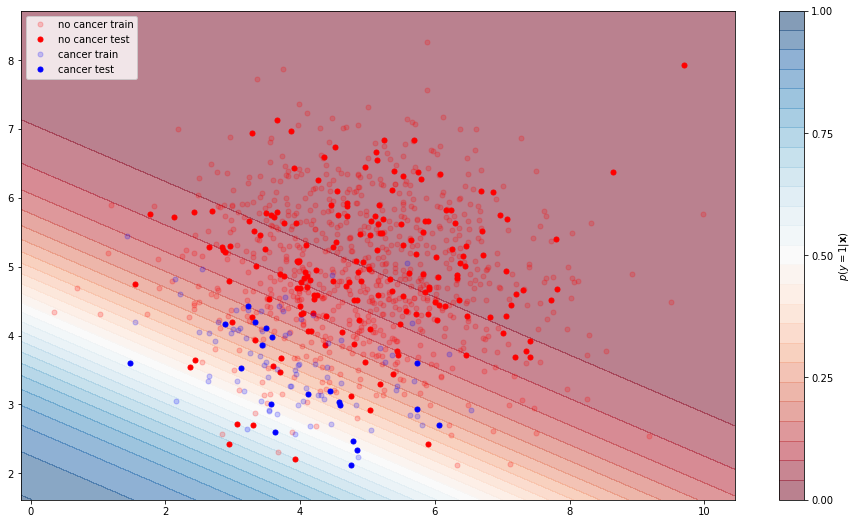

In [5]:
lr = LR()
lr.fit(X_train, y_train)

# plot the probability contours of the classifier
def plot_contour(clf, x):
    xmin, xmax = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    ymin, ymax = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    xx, yy = np.mgrid[xmin:xmax:.1, ymin:ymax.max():.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
    contour = pl.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1, alpha=0.5)
    ax_c = pl.colorbar(contour)
    ax_c.set_label("$p(y = 1 | \mathbf{x})$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

pl.figure(figsize=FIGSIZE)
plot_contour(lr, X)
plot_split_data()

## Validate the performance of the classifier

OK, lets now validate the logistic regressor with a decision threshold of $p(y^* = \text{cancer}~| \mathbf{x}^*) > 0.5$. 

In [6]:
res = res.append(score_classifier(lr, "Unweighted, p > 0.5"))
display(HTML(res.to_html()))

,Accuracy,FPR,Log loss,Precision,Recall (TPR)
Negative,0.900,0.000000,NaN,0.000000,0.00
Random,0.835,0.072222,0.325083,0.000000,0.00
"Unweighted, p > 0.5",0.895,0.022222,0.201535,0.428571,0.15


The logistic regressor isn't really doing much better than the naive classifiers on this unbalanced data!! :-(

**This is why it so important to pick the right validation measure!**

## Fix 1: Change the decision threshold
A receiver operator charactersitic (ROC) curve is a nice way to see how our classifier performs as a function of its decision threshold

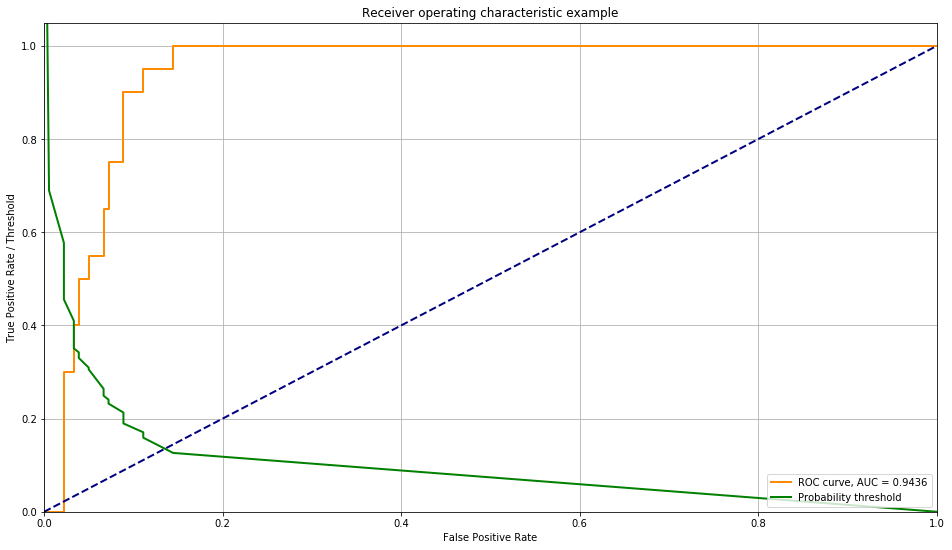

In [7]:
# Get probabilistic prediction
def plot_roc_curve(py):
    fpr, tpr, thresholds = roc_curve(y_test, py[:, 1])
    roc_auc = auc(fpr, tpr)

    lw = 2
    pl.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve, AUC = {:.4f}'.format(roc_auc))
    pl.plot(fpr, thresholds, color='green', lw=lw, label='Probability threshold')
    pl.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate / Threshold')
    pl.title('Receiver operating characteristic example')
    pl.grid()
    pl.legend(loc="lower right")

py = lr.predict_proba(X_test)
pl.figure(figsize=FIGSIZE)
plot_roc_curve(py)
pl.show()

Looks like we may be better off with $p(y^* = \text{cancer}~| \mathbf{x}^*) > 0.1$. 

In [8]:
y_bar = py[:, 1] > 0.1

res = res.append(score_result(y_bar, "Unweighted, p > 0.1", py))
display(HTML(res.to_html()))

,Accuracy,FPR,Log loss,Precision,Recall (TPR)
Negative,0.900,0.000000,NaN,0.000000,0.00
Random,0.835,0.072222,0.325083,0.000000,0.00
"Unweighted, p > 0.5",0.895,0.022222,0.201535,0.428571,0.15
"Unweighted, p > 0.1",0.830,0.188889,0.201535,0.370370,1.00


Much better! But we have lost some accuracy...

## Fix 2: Re-weight the learning objective

Another fix is to not treat all points equally in the learning algorithm:

This was originally:

$\argmin_{\mathbf{w}} - \frac{1}{N} \sum^N_{i=1} \log \text{Bernoulli}\!\left(y_i | \sigma(\mathbf{x_i}^\top\mathbf{w})\right)$,

Now we can change it:

$\argmin_{\mathbf{w}} - \sum^N_{i=1} \rho_i \log \text{Bernoulli}\!\left(y_i | \sigma(\mathbf{x_i}^\top\mathbf{w})\right)$,

Where we now set $\rho_i$ as a function of the true label such that each class has equal weight in the objective! 

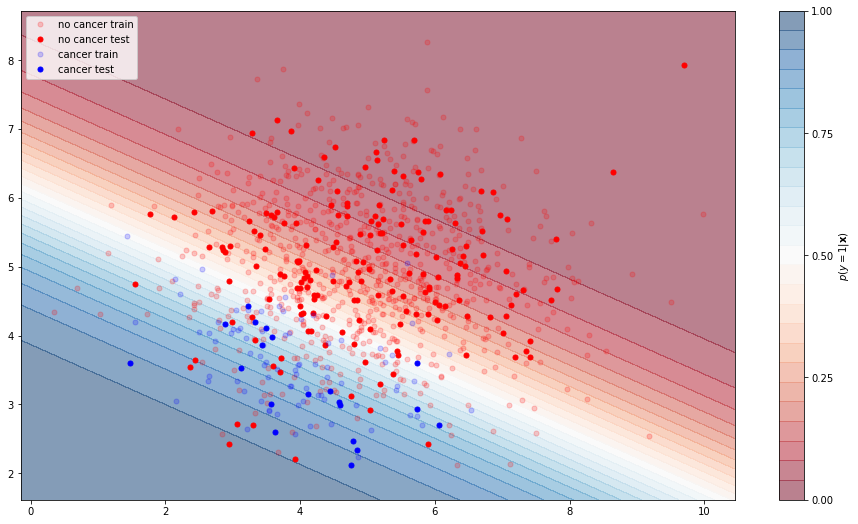

,Accuracy,FPR,Log loss,Precision,Recall (TPR)
Negative,0.900,0.000000,NaN,0.000000,0.00
Random,0.835,0.072222,0.325083,0.000000,0.00
"Unweighted, p > 0.5",0.895,0.022222,0.201535,0.428571,0.15
"Unweighted, p > 0.1",0.830,0.188889,0.201535,0.370370,1.00
"Weighted, p > 0.5",0.855,0.155556,0.385093,0.404255,0.95


In [9]:
wlr = LR(class_weight='balanced')
wlr.fit(X_train, y_train)

pl.figure(figsize=FIGSIZE)
plot_contour(wlr, X)
plot_split_data()

res = res.append(score_classifier(wlr, "Weighted, p > 0.5"))
display(HTML(res.to_html()))

- This has a very similar effect as choosing a threshold, but **our probabilities do not reflect the base rates of the data** anymore (i.e. we have lost "calibration")...
- This is useful for other classifier that aren't probabilistic - e.g. max margin (SVMs), and arguably is the right "loss"
- Also, things get a bit more complicated in highly non-linear problems (very different decision boundaries may be learned when weighting objectives)
- It's all about the right objective function, and right measures of performance.

# Effect of weighting a non-linear classifier

Let's see what the effect is of weighting a non-linear classifier.
- We'll use a support vector machine for this
- In this case the decision function is not based on probability

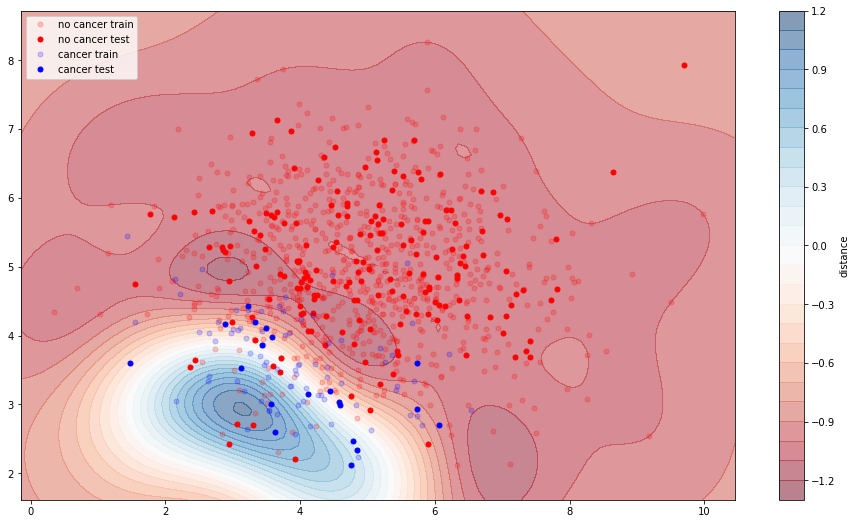

,Accuracy,FPR,Log loss,Precision,Recall (TPR)
Negative,0.900,0.000000,NaN,0.000000,0.00
Random,0.835,0.072222,0.325083,0.000000,0.00
"Unweighted, p > 0.5",0.895,0.022222,0.201535,0.428571,0.15
"Unweighted, p > 0.1",0.830,0.188889,0.201535,0.370370,1.00
"Weighted, p > 0.5",0.855,0.155556,0.385093,0.404255,0.95
SVC,0.895,0.044444,NaN,0.466667,0.35


In [10]:
# Unweighted
svc = SVC()
svc.fit(X_train, y_train)

def plot_svm_contour(clf, x):
    xmin, xmax = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    ymin, ymax = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    xx, yy = np.mgrid[xmin:xmax:.1, ymin:ymax.max():.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    dist = clf.decision_function(grid).reshape(xx.shape)
    contour = pl.contourf(xx, yy, dist, 25, cmap="RdBu", alpha=0.5)
    ax_c = pl.colorbar(contour)
    ax_c.set_label("distance")
    
pl.figure(figsize=FIGSIZE)
plot_svm_contour(svc, X)
plot_split_data()

res = res.append(score_classifier(svc, "SVC"))
display(HTML(res.to_html()))

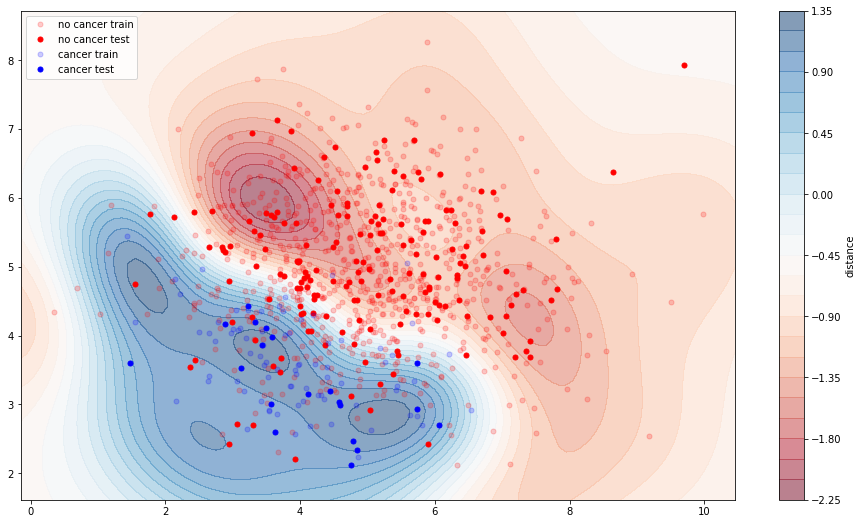

,Accuracy,FPR,Log loss,Precision,Recall (TPR)
Negative,0.900,0.000000,NaN,0.000000,0.00
Random,0.835,0.072222,0.325083,0.000000,0.00
"Unweighted, p > 0.5",0.895,0.022222,0.201535,0.428571,0.15
"Unweighted, p > 0.1",0.830,0.188889,0.201535,0.370370,1.00
"Weighted, p > 0.5",0.855,0.155556,0.385093,0.404255,0.95
SVC,0.895,0.044444,NaN,0.466667,0.35
Weighted SVC,0.840,0.177778,NaN,0.384615,1.00


In [11]:
# Weighted
wsvc = SVC(class_weight='balanced')
wsvc.fit(X_train, y_train)

pl.figure(figsize=FIGSIZE)
plot_svm_contour(wsvc, X)
plot_split_data()

res = res.append(score_classifier(wsvc, "Weighted SVC"))
display(HTML(res.to_html()))

As expected, this changes the decision boundary quite significantly and we cannot acheive the same result by choosing a different a decision threshold on the same classifier.

## Other fixes
- Subsample larger class, but throw away data
- "Up sample" smaller class (using NN, SMOTE), but have to model $p(\mathbf{x} | y)$

This was inspired by:
https://www.youtube.com/watch?v=-Z1PaqYKC1w